In [2]:
#| hide
%load_ext autoreload
%autoreload 2

In [3]:
from discontinuitypy.core.pipeline import ids_finder
from discontinuitypy.datasets import IDsDataset
from discontinuitypy.utils.basic import resample
from space_analysis.missions.psp.mag import load_data
from space_analysis.missions.psp.plasma import load_data as load_data_plasma
import polars as pl
from beforerr.polars import pl_norm

from sunpy.time import TimeRange
from datetime import timedelta
# from ids_finder.missions.psp.mag import load_data, download_data

In [4]:
start = '2019-04-06T12:00'
start = '2019-04-07T01:00'
end = '2019-04-07T12:00'

earth_start = '2019-04-09'
earth_end = '2019-04-14'

In [5]:
psp_timerange = TimeRange(start, end)
timerange_earth = TimeRange(earth_start, earth_end)

In [6]:
def validate(timerange):
    if isinstance(timerange, TimeRange):
        return [timerange.start.to_string(), timerange.end.to_string()]

In [7]:
# tau = timedelta(seconds=60)
tau = timedelta(seconds=10)
ts = timedelta(seconds=1/264)

In [8]:
validate(psp_timerange)

['2019-04-07T01:00:00.000', '2019-04-07T12:00:00.000']

In [9]:
data = load_data(trange = validate(psp_timerange))

03-Feb-24 13:37:27 INFO     03-Feb-24 13:37:27: Downloading      ]8;id=785859;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pyspedas/utilities/download.py\download.py]8;;\:]8;id=99875;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pyspedas/utilities/download.py#343\343]8;;\
                            remote index:                                       
                            https://spdf.gsfc.nasa.gov/pub/data/                
                            psp/fields/l2/mag_rtn/2019/                         
03-Feb-24 13:37:28 INFO     03-Feb-24 13:37:28: File is current: ]8;id=884011;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pyspedas/utilities/download.py\download.py]8;;\:]8;id=741805;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pyspedas/utilities/download.py#140\140]8;;\
                            /Users/zijin/data/psp/fi

In [10]:
#| output: false
candidate = ids_finder(data, tau, ts)

To remove this warning, run the following python code before doing dataframe operations:

    import ray
    ray.init()

2024-02-03 13:37:33,797	INFO worker.py:1724 -- Started a local Ray instance.


Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

03-Feb-24 13:37:34 INFO     03-Feb-24 13:37:34: Using    ]8;id=843215;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/modin/core/execution/ray/implementations/pandas_on_ray/partitioning/partition_manager.py\partition_manager.py]8;;\:]8;id=604426;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/modin/core/execution/ray/implementations/pandas_on_ray/partitioning/partition_manager.py#89\89]8;;\
                            sequential splitting in                             
                            '.from_pandas()' because of                         
                            some of the conditions are                          
                            False:                                              
                            enough_elements=False;                              
                            all_numeric_types=False;                            
                            async_mode_on=Fals

(_deploy_ray_func pid=57046) UserWarning: Traceback (most recent call last):
(_deploy_ray_func pid=57046)   File "/Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pdpipe/__init__.py", line 85, in <module>
(_deploy_ray_func pid=57046)     from . import skintegrate
(_deploy_ray_func pid=57046)   File "/Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pdpipe/skintegrate.py", line 20, in <module>
(_deploy_ray_func pid=57046)     from sklearn.base import BaseEstimator
(_deploy_ray_func pid=57046) ModuleNotFoundError: No module named 'sklearn'
(_deploy_ray_func pid=57046) 
(_deploy_ray_func pid=57046) UserWarning: pdpipe: Scikit-learn or skutil import failed. Scikit-learn-dependent pipeline stages will not be loaded.
(_deploy_ray_func pid=57046) UserWarning: Traceback (most recent call last):
(_deploy_ray_func pid=57046)   File "/Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pdpipe/__init__.py", line 105, in <module>

Estimated completion of line 1:   0%           Elapsed time: 00:00, estimated remaining time: ?

(_deploy_ray_func pid=57044) RuntimeWarning: overflow encountered in exp
(_deploy_ray_func pid=57044) RuntimeWarning: overflow encountered in exp


Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

03-Feb-24 13:37:38 INFO     03-Feb-24 13:37:38: Using    ]8;id=976071;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/modin/core/execution/ray/implementations/pandas_on_ray/partitioning/partition_manager.py\partition_manager.py]8;;\:]8;id=857184;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/modin/core/execution/ray/implementations/pandas_on_ray/partitioning/partition_manager.py#89\89]8;;\
                            sequential splitting in                             
                            '.from_pandas()' because of                         
                            some of the conditions are                          
                            False:                                              
                            enough_elements=False;                              
                            all_numeric_types=False;                            
                            async_mode_on=Fals

Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

                   INFO     03-Feb-24 13:37:38: Using    ]8;id=467188;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/modin/core/execution/ray/implementations/pandas_on_ray/partitioning/partition_manager.py\partition_manager.py]8;;\:]8;id=262437;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/modin/core/execution/ray/implementations/pandas_on_ray/partitioning/partition_manager.py#89\89]8;;\
                            sequential splitting in                             
                            '.from_pandas()' because of                         
                            some of the conditions are                          
                            False:                                              
                            enough_elements=False;                              
                            all_numeric_types=True;                             
                            async_mode_on=Fals

Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

                   INFO     03-Feb-24 13:37:38: Using    ]8;id=841824;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/modin/core/execution/ray/implementations/pandas_on_ray/partitioning/partition_manager.py\partition_manager.py]8;;\:]8;id=250849;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/modin/core/execution/ray/implementations/pandas_on_ray/partitioning/partition_manager.py#89\89]8;;\
                            sequential splitting in                             
                            '.from_pandas()' because of                         
                            some of the conditions are                          
                            False:                                              
                            enough_elements=False;                              
                            all_numeric_types=False;                            
                            async_mode_on=Fals

In [25]:
psp_ids_dataset = IDsDataset(
    candidates = candidate,
    data = data
)

## Examples of discontinuities observed by PSP

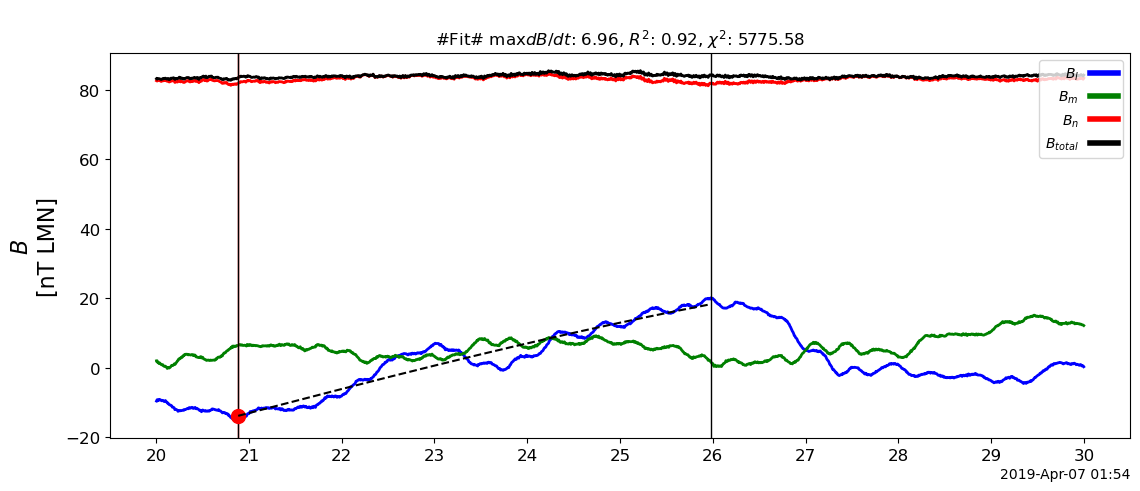

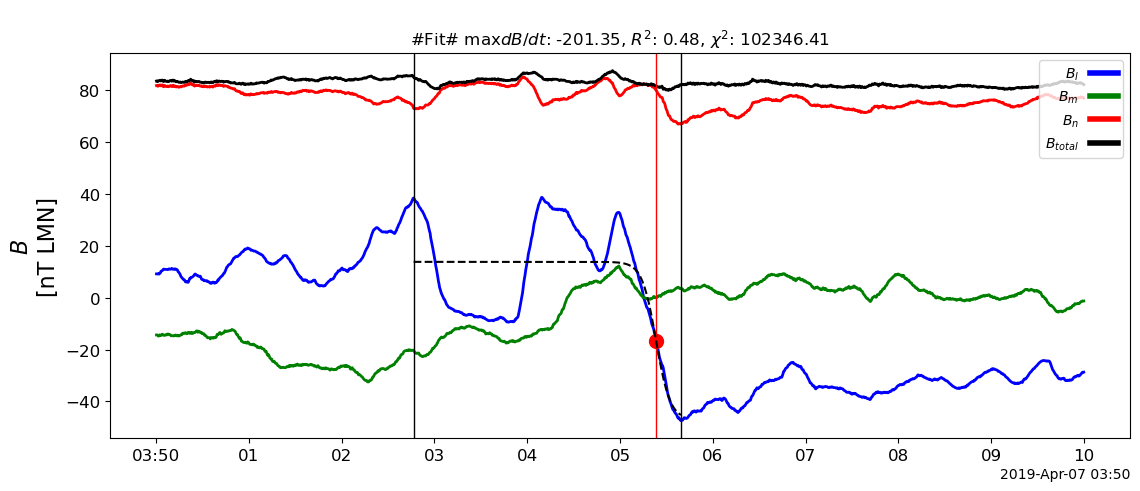

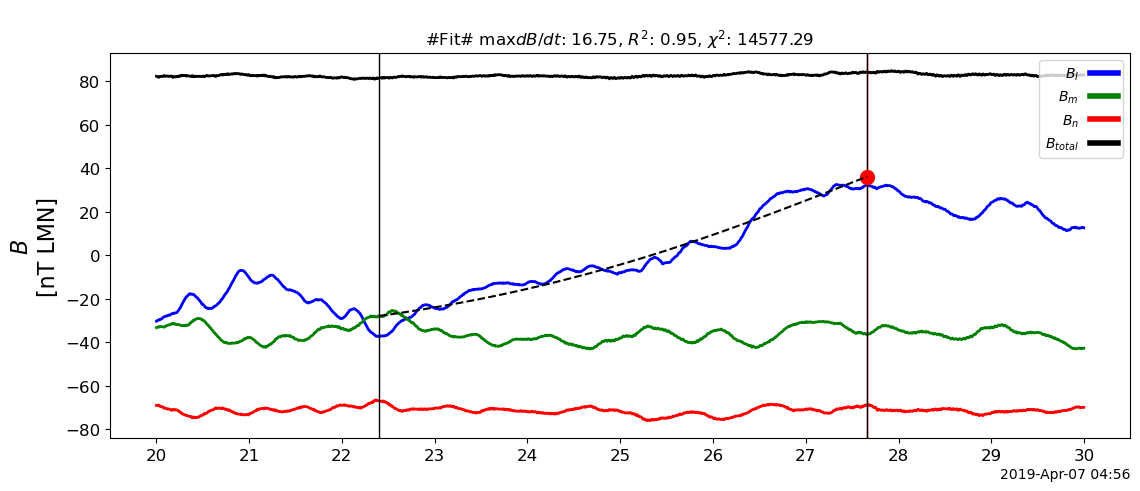

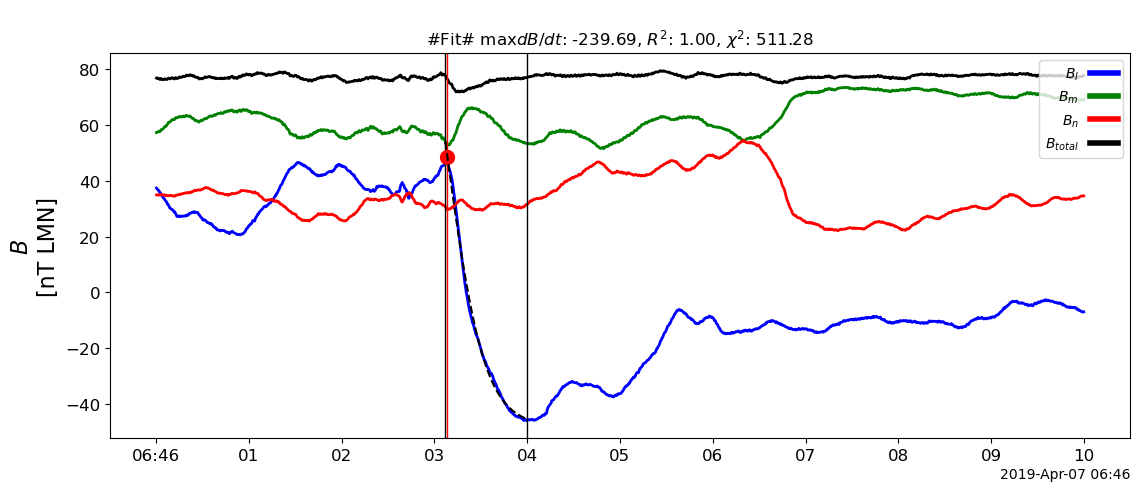

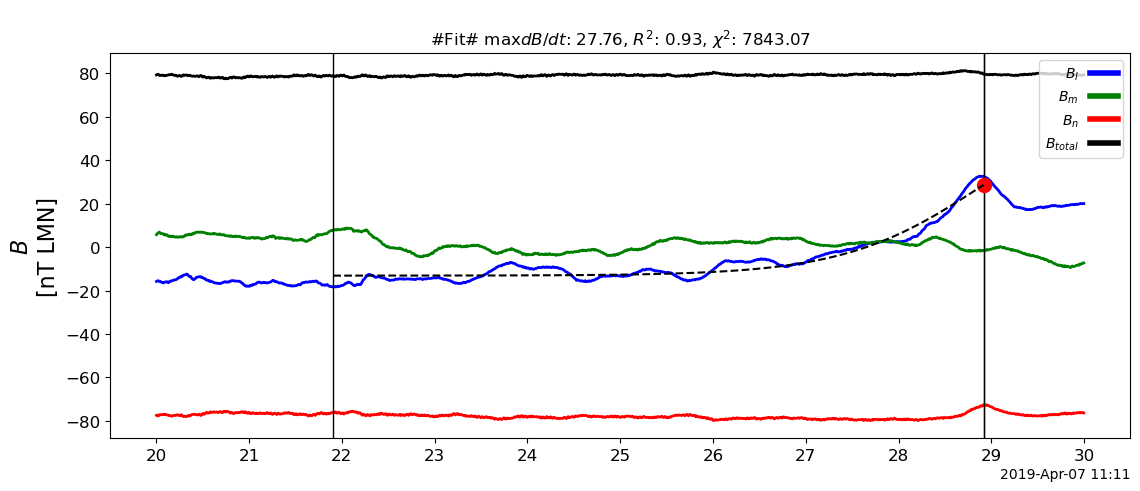

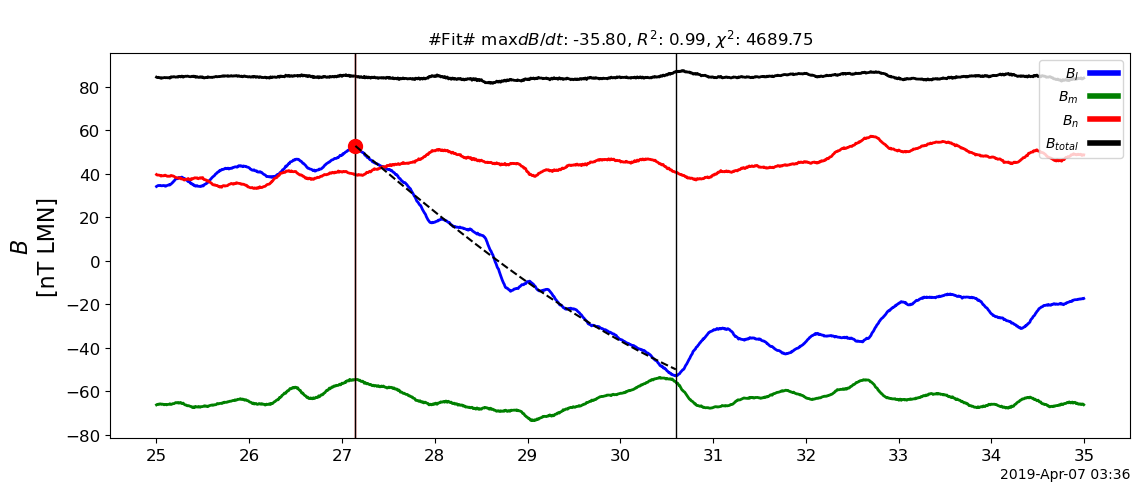

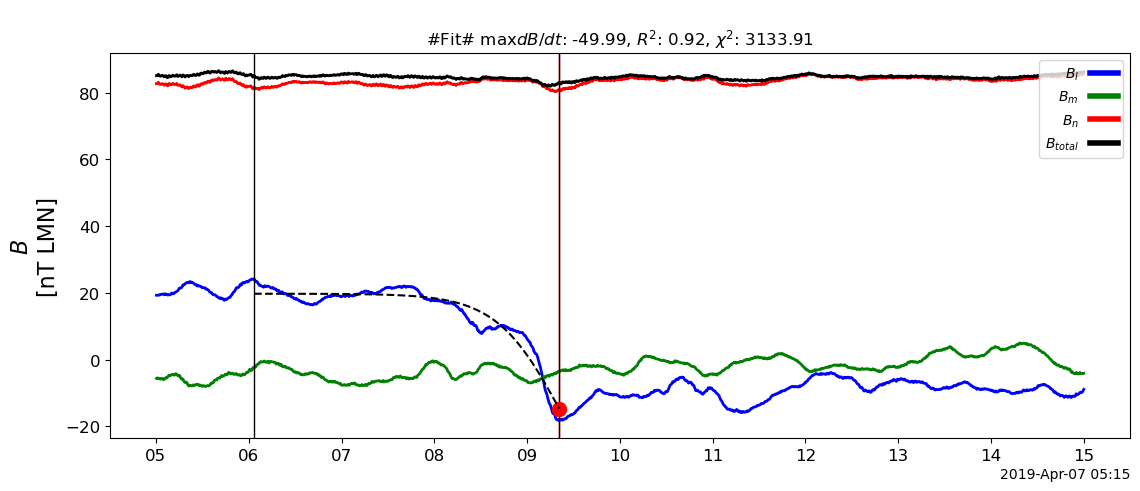

In [26]:
#| column: screen
#| layout-ncol: 3
bad_indices = [16, 32, 40, 60, 78, 122, 139]
outs = psp_ids_dataset.plot_candidates(bad_indices, plot_fit_data=True)

2024-02-03 13:38:44.303 | INFO     | discontinuitypy.datasets:plot_candidates:67 - Candidates indices: [136, 7, 21, 92]


[(<Figure size 1200x500 with 1 Axes>,
  <Axes: title={'center': '\n#Fit# $\\max dB/dt$: -232542764.06, $R^2$: 0.28, $\\chi^2$: 176208.19'}, ylabel='$B$\n[nT LMN]'>),
 (<Figure size 1200x500 with 1 Axes>,
  <Axes: title={'center': '\n#Fit# $\\max dB/dt$: 57.19, $R^2$: 0.88, $\\chi^2$: 59711.62'}, ylabel='$B$\n[nT LMN]'>),
 (<Figure size 1200x500 with 1 Axes>,
  <Axes: title={'center': '\n#Fit# $\\max dB/dt$: 5.44, $R^2$: 0.97, $\\chi^2$: 3759.00'}, ylabel='$B$\n[nT LMN]'>),
 (<Figure size 1200x500 with 1 Axes>,
  <Axes: title={'center': '\n#Fit# $\\max dB/dt$: 101.35, $R^2$: 1.00, $\\chi^2$: 1250.19'}, ylabel='$B$\n[nT LMN]'>)]

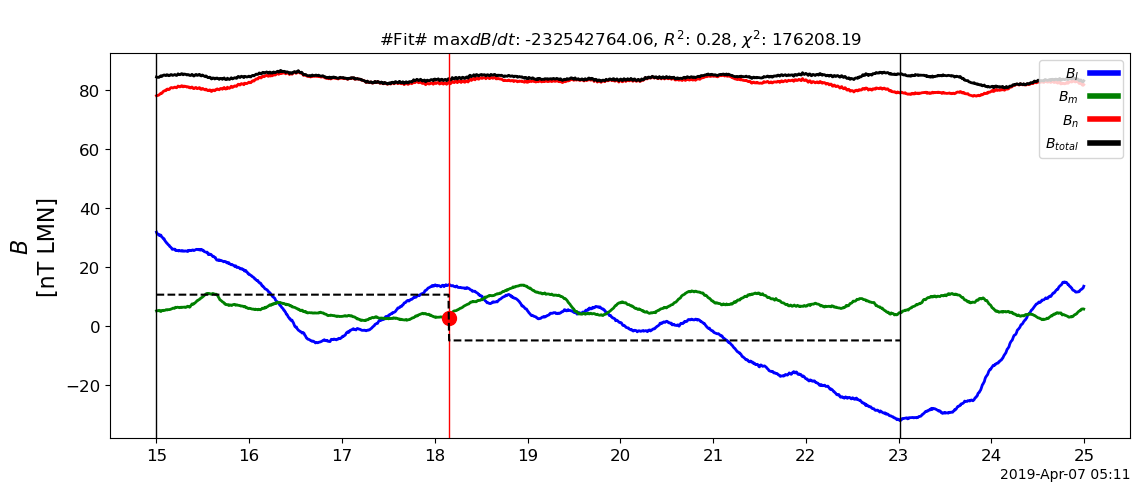

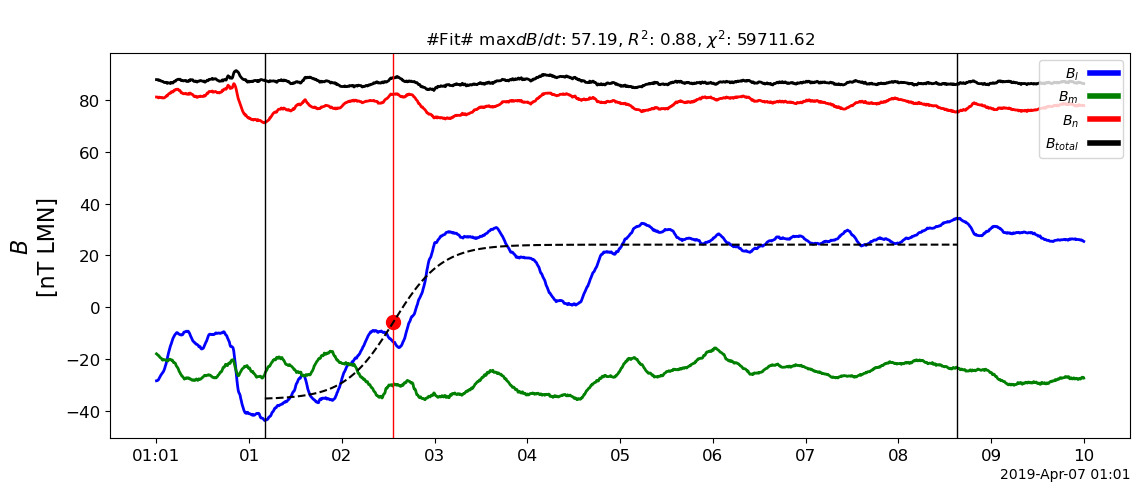

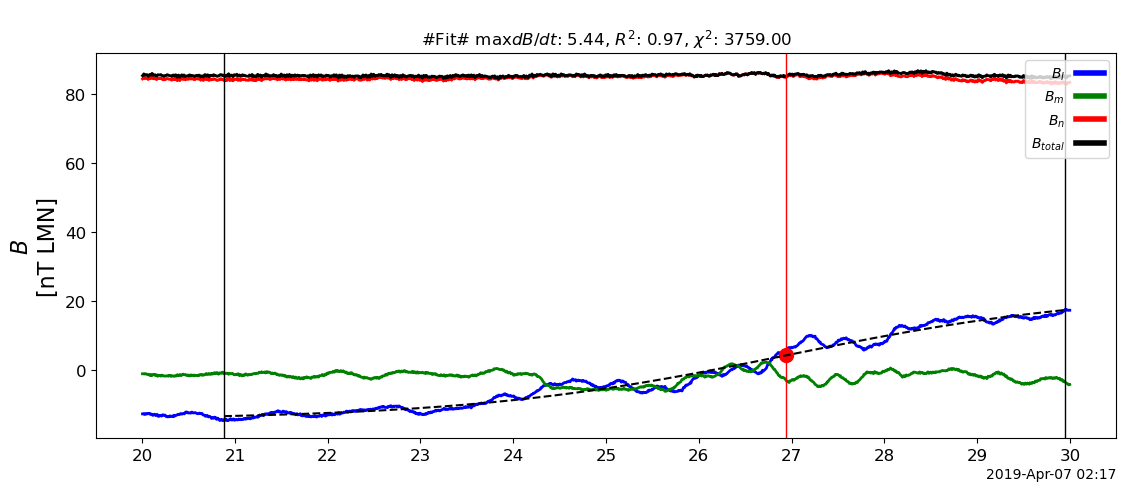

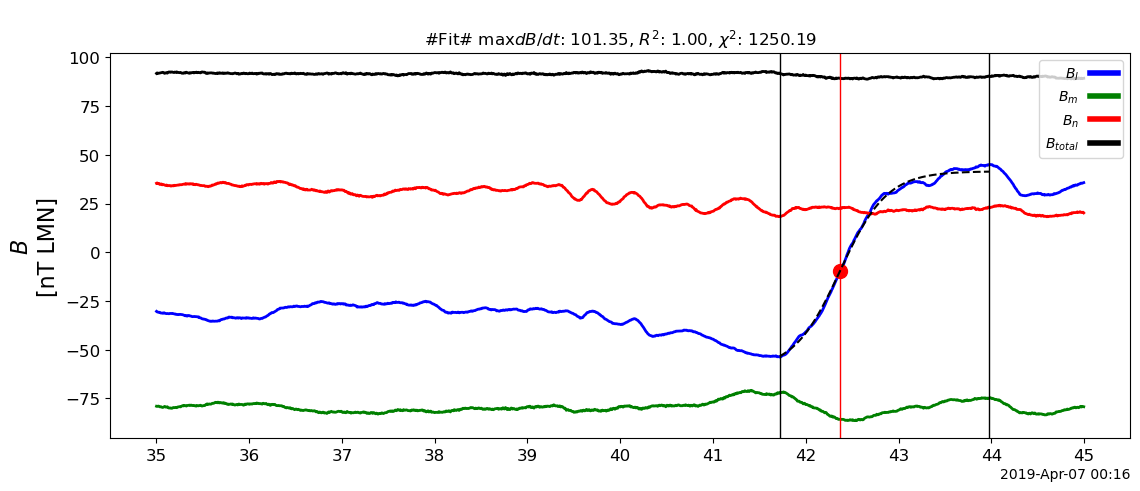

In [13]:
#| column: screen
#| layout-ncol: 3

outs = psp_ids_dataset.plot_candidates(plot_fit_data=True)
# good_indices = [87, 285, 121, 128, 69, 282, 81]
# figs = psp_ids_dataset.plot_candidates(good_indices, display=False)

## Resampled dataset

By visually inspecting data, the most strong discontinuities kind of have time duration about 1-3 seconds. 
So it is reasonable to downsample the data to a lower frequency so that 

- the detection method is more robust, excluding very high frequency wave/noise?
- it is better to apply the derivative method to get the properties of the discontinuities.
- Match `Wind` time resolution.

Or we could fit the $B_l$ to get the properties of the discontinuities.

In [14]:
every = timedelta(seconds=1/11)

# tau = timedelta(seconds=60)
tau = timedelta(seconds=10)
ts = timedelta(seconds=1/11)

data_r = resample(data, every)

In [15]:
candidates_r = ids_finder(data_r, tau, ts)

Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

03-Feb-24 13:38:50 INFO     03-Feb-24 13:38:50: Using    ]8;id=609617;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/modin/core/execution/ray/implementations/pandas_on_ray/partitioning/partition_manager.py\partition_manager.py]8;;\:]8;id=792620;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/modin/core/execution/ray/implementations/pandas_on_ray/partitioning/partition_manager.py#89\89]8;;\
                            sequential splitting in                             
                            '.from_pandas()' because of                         
                            some of the conditions are                          
                            False:                                              
                            enough_elements=False;                              
                            all_numeric_types=False;                            
                            async_mode_on=Fals

(_deploy_ray_func pid=57046) UserWarning: Distributing <class 'dict'> object. This may take some time.
Distributing Dataframe: 100%██████████ Elapsed time: 00:00, estimated remaining time: 00:00
(_deploy_ray_func pid=57046) UserWarning: Distributing <class 'dict'> object. This may take some time.
Distributing Dataframe: 100%██████████ Elapsed time: 00:00, estimated remaining time: 00:00
(_deploy_ray_func pid=57046) UserWarning: Distributing <class 'dict'> object. This may take some time.
Distributing Dataframe: 100%██████████ Elapsed time: 00:00, estimated remaining time: 00:00
(_deploy_ray_func pid=57046) UserWarning: Distributing <class 'dict'> object. This may take some time.
Distributing Dataframe: 100%██████████ Elapsed time: 00:00, estimated remaining time: 00:00
(_deploy_ray_func pid=57046) UserWarning: Distributing <class 'dict'> object. This may take some time.
Distributing Dataframe: 100%██████████ Elapsed time: 00:00, estimated remaining time: 00:00
(_deploy_ray_func pid=570

Estimated completion of line 1:   0%           Elapsed time: 00:00, estimated remaining time: ?

Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

03-Feb-24 13:38:52 INFO     03-Feb-24 13:38:52: Using    ]8;id=431825;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/modin/core/execution/ray/implementations/pandas_on_ray/partitioning/partition_manager.py\partition_manager.py]8;;\:]8;id=987095;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/modin/core/execution/ray/implementations/pandas_on_ray/partitioning/partition_manager.py#89\89]8;;\
                            sequential splitting in                             
                            '.from_pandas()' because of                         
                            some of the conditions are                          
                            False:                                              
                            enough_elements=False;                              
                            all_numeric_types=False;                            
                            async_mode_on=Fals

Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

                   INFO     03-Feb-24 13:38:52: Using    ]8;id=967324;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/modin/core/execution/ray/implementations/pandas_on_ray/partitioning/partition_manager.py\partition_manager.py]8;;\:]8;id=314004;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/modin/core/execution/ray/implementations/pandas_on_ray/partitioning/partition_manager.py#89\89]8;;\
                            sequential splitting in                             
                            '.from_pandas()' because of                         
                            some of the conditions are                          
                            False:                                              
                            enough_elements=False;                              
                            all_numeric_types=True;                             
                            async_mode_on=Fals

Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

                   INFO     03-Feb-24 13:38:52: Using    ]8;id=646039;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/modin/core/execution/ray/implementations/pandas_on_ray/partitioning/partition_manager.py\partition_manager.py]8;;\:]8;id=674590;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/modin/core/execution/ray/implementations/pandas_on_ray/partitioning/partition_manager.py#89\89]8;;\
                            sequential splitting in                             
                            '.from_pandas()' because of                         
                            some of the conditions are                          
                            False:                                              
                            enough_elements=False;                              
                            all_numeric_types=False;                            
                            async_mode_on=Fals

In [16]:
var_names = ["DENS", "VEL_RTN_SUN", "TEMP", "SUN_DIST"]
vec_cols=[f"VEL_RTN_SUN_{i}" for i in range(3)]

psp_plasma = load_data_plasma(trange = validate(psp_timerange), var_names=var_names)
psp_plasma_r = psp_plasma.pipe(resample, every=tau).with_columns(
    plasma_speed = pl_norm(vec_cols)
).rename({
    "DENS": "plasma_density",
    "TEMP": "plasma_temperature",
})

Using LEVEL=L3
03-Feb-24 13:39:01 INFO     03-Feb-24 13:39:01: Downloading      ]8;id=416889;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pyspedas/utilities/download.py\download.py]8;;\:]8;id=656269;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pyspedas/utilities/download.py#343\343]8;;\
                            remote index:                                       
                            https://spdf.gsfc.nasa.gov/pub/data/                
                            psp/sweap/spi/l3/spi_sf00_l3_mom/201                
                            9/                                                  
                   INFO     03-Feb-24 13:39:01: File is current: ]8;id=519333;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pyspedas/utilities/download.py\download.py]8;;\:]8;id=600180;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/py

In [17]:
psp_ids_dataset = IDsDataset(
    candidates = candidates_r,
    data = data_r,
    plasma_data = psp_plasma_r,
    vec_cols = vec_cols
)

psp_ids_dataset.update_candidates_with_plasma_data()

In [20]:
def ids_filter(df: pl.DataFrame):
    return df.filter(
        pl.col('index_diff')>1, # interested in strong discontinuities
        pl.col('fit.stat.rsquared')>0.9, # interested in good fits
    )

2024-02-03 13:48:08.810 | INFO     | discontinuitypy.datasets:plot_candidates:67 - Candidates indices: [6, 21, 13, 9]


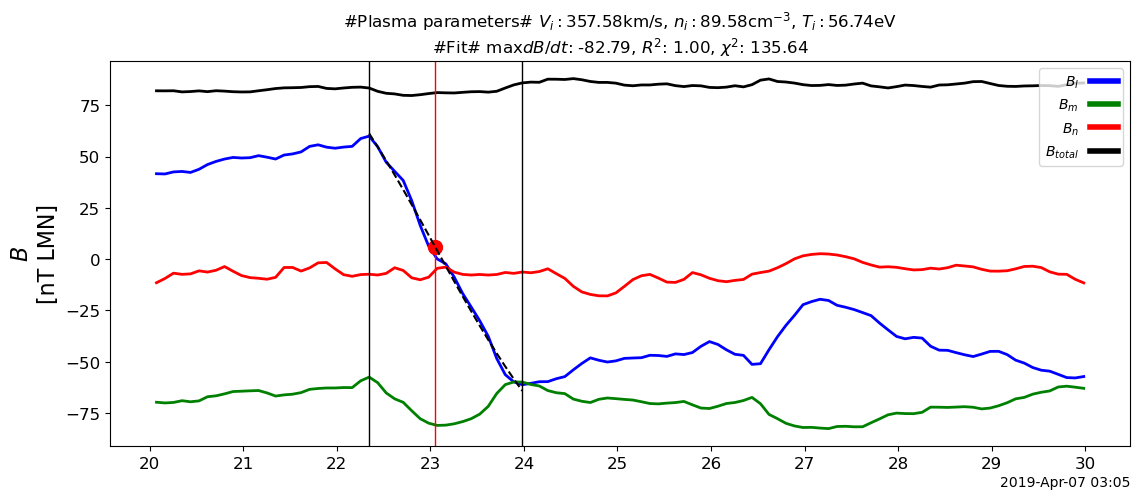

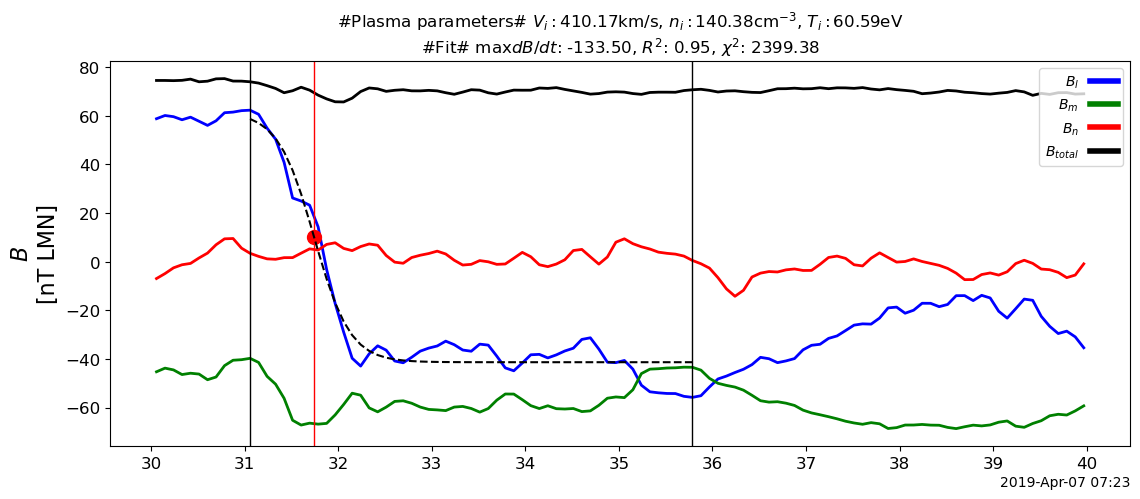

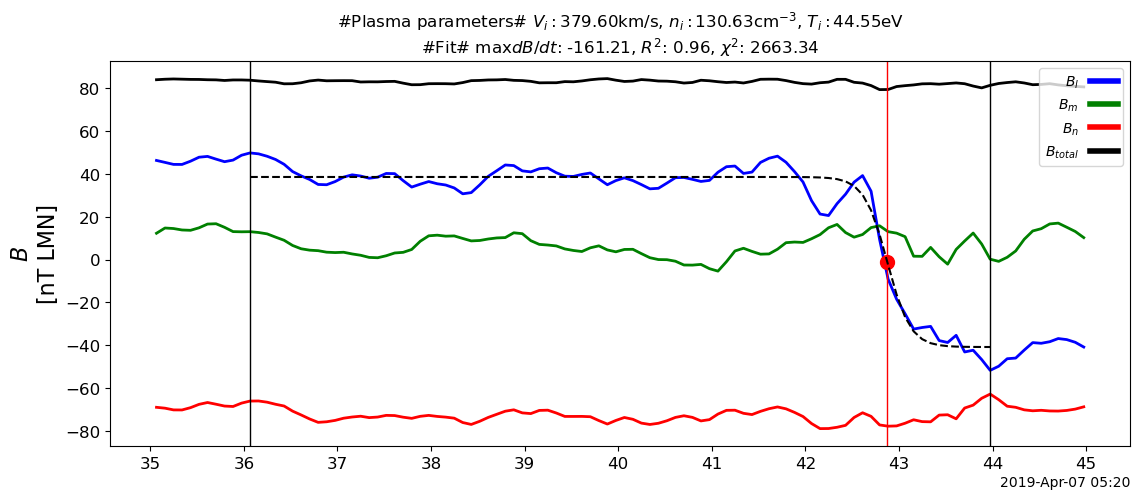

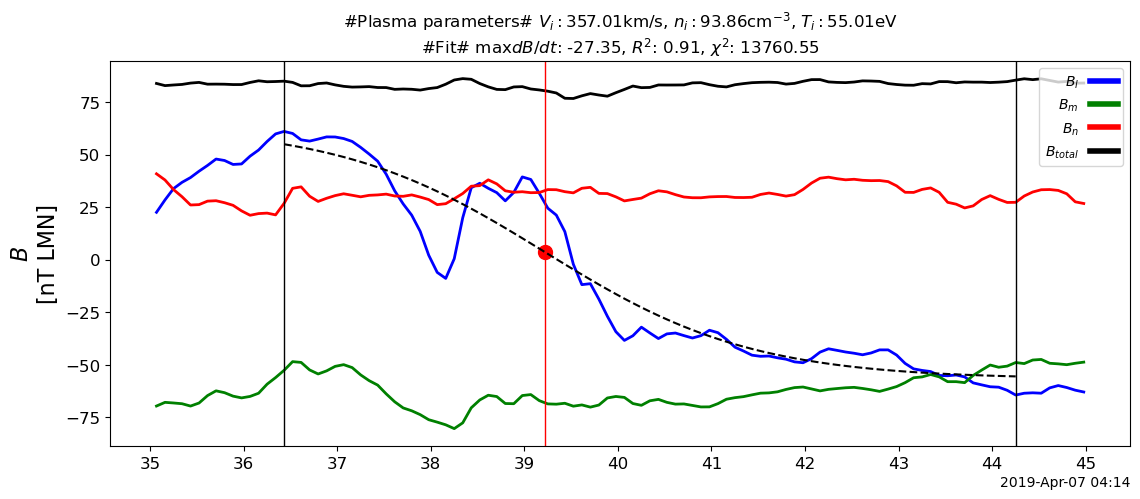

In [23]:
#| column: screen
#| layout-ncol: 3
outs = psp_ids_dataset.plot_candidates(add_plasma_params=True, plot_fit_data=True)